In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam, rmsprop, sgd
from keras.callbacks import EarlyStopping
import keras.backend as Ka
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import KFold
from numpy import array
from keras import optimizers
import pandas as pd

import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd
from datetime import datetime
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM


Using TensorFlow backend.


# 1. Importation et préparation des données

In [2]:
immo = pd.read_csv('../../data/join/immo_by_month_100.csv')

In [3]:
immo['mois'] = immo['month'] + (immo['year'] - 2014) * 12

In [4]:
immo = immo.drop(columns = ['month','year'])

In [5]:
immo = immo.sort_values(by=['id_bien_int','mois'])

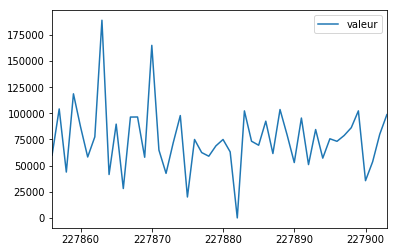

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

df = immo[immo.id_bien_int == 62524]
# gca stands for 'get current axis'
ax = plt.gca()
df.plot(kind='line',y='valeur',ax=ax)
plt.show()

In [8]:
train_lstm = immo[['id_bien_int','valeur']].groupby(by = 'id_bien_int')['valeur'].apply(list)

In [9]:
train_lstm.index = train_lstm.index.map(lambda x : 'valeur_' + str(x))

In [10]:
train_lstm = pd.DataFrame.from_items(zip(train_lstm.index, train_lstm.values))

/home/yopla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



In [11]:
train_lstm.shape

(48, 4750)

In [12]:
train_lstm.iloc[41,9]

234671.66666666663

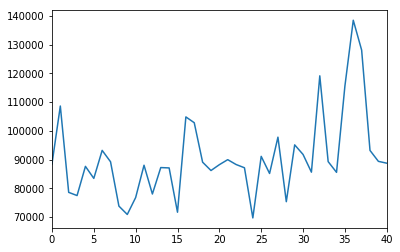

In [15]:
df = train_lstm.iloc[0:41,4]
# gca stands for 'get current axis'
ax = plt.gca()
df.plot(kind='line',y='valeur',ax=ax)
plt.show()

In [13]:
train_lstm['mois'] = list(train_lstm.index) 
train_lstm['mois'] = train_lstm['mois'] + 1

In [14]:
train_lstm.head()

,valeur_16,valeur_26,valeur_34,valeur_40,valeur_50,valeur_54,valeur_62,valeur_73,valeur_83,valeur_99,...,valeur_62471,valeur_62474,valeur_62475,valeur_62486,valeur_62493,valeur_62503,valeur_62524,valeur_62528,valeur_62538,mois
0,244117.392000,131500.000000,90000.0,84706.666667,88445.974186,232693.333333,298444.444444,124000.000000,121752.322222,673992.033333,...,224477.7,75574.766000,2.064125e+06,198666.666667,114575.000000,241320.0,60000.000000,82000.0,157847.142857,1
1,256866.666667,131250.000000,135500.0,119333.333333,108634.894262,206416.333333,339204.285714,251333.333333,128331.938889,0.000000,...,220148.0,95100.677500,2.366233e+06,162679.000000,189000.000000,380260.0,104200.000000,102525.0,124895.833333,2
2,193337.500000,195666.666667,288250.0,87000.000000,78599.545455,126333.333333,204033.333333,161280.000000,105012.038571,77000.000000,...,245000.0,96732.258571,1.641114e+06,0.000000,84666.666667,0.0,43850.000000,88950.0,153365.384615,3
3,181700.000000,247550.000000,38887.5,67625.000000,77488.644444,122500.000000,303125.000000,142012.500000,120336.956000,142666.666667,...,164500.0,113500.000000,2.152680e+06,466644.431111,160000.000000,315000.0,118666.666667,89000.0,124774.666667,4
4,184250.000000,195000.000000,78580.0,49000.000000,87641.294872,184600.000000,335242.857143,178250.000000,121007.746667,177500.000000,...,199925.0,113287.500000,2.265530e+06,0.000000,93000.000000,224980.0,87000.000000,0.0,150973.600000,5


In [15]:
n_features = train_lstm.shape[1]-1

In [16]:
n_input = 12

In [17]:
kernel_initialiser = 'normal'
model = Sequential()

#model.add(LSTM(300, activation='relu',  return_sequences=True, input_shape=(n_input, n_features),kernel_initializer=kernel_initialiser))
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features),kernel_initializer=kernel_initialiser))
model.add(Dense(50, activation='relu',kernel_initializer=kernel_initialiser))

#model.add(Dense(100, activation='relu',kernel_initializer=kernel_initialiser))


model.add(Dense(n_features, activation='relu',kernel_initializer=kernel_initialiser))
sgd = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=sgd, loss='mean_absolute_error')

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
from sklearn.metrics import mean_squared_log_error
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [19]:
predictions = train_lstm.copy()
predictions['type'] = 'reel'


In [20]:
from sklearn.ensemble import RandomForestRegressor
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', verbose=1, patience=30)

deb_month_prediction = 40

train_lstm2 = predictions[(predictions.mois < deb_month_prediction) & (predictions.type == 'reel') | (predictions.type == 'predit') ].drop(columns=['type'])


mean_error = []
for mois in range(deb_month_prediction,46):
    
    
    print("mois : " + str(mois))
    
    
    train = train_lstm2[train_lstm2.mois < mois].drop(columns='mois')
    
    val = train_lstm[train_lstm.mois == mois].drop(columns='mois')
    train2  = train_lstm2[train_lstm2.mois < mois + 1].drop(columns='mois')
    
    n_input = 12
    generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=64)
    generator2 = TimeseriesGenerator(train2.values, train2.values, length=n_input, batch_size=1)
    
    len_gene = len(generator)
    len_gene2 = len(generator2)
    
    # test_headline_data = val['id_bien']
    # test_additional_data = val.drop(columns=['id_bien','valeur','mois'])
    # test_labels = val['valeur']
    
    # headline_data = train['id_bien']
    # additional_data = train.drop(columns=['id_bien','valeur','mois'])
    # labels = train['valeur']
    
    val = val.values

    
    model.fit_generator(generator, steps_per_epoch=1, epochs=1000, callbacks=[es])
    
    x=generator2[len_gene2-1][0]
    
    # make a one step prediction out of sample
    #x_input = array([[90, 95], [100, 105]]).reshape((1, n_input, n_features))
    yhat = model.predict(x, verbose=0)
    
    yhat = pd.DataFrame(yhat)
    yhat['mois'] = mois
    yhat['type'] = 'predit'  

    yhat.columns = predictions.columns.values
    
    
    predictions = pd.concat([ predictions,yhat])
    
    #model.fit([headline_data, additional_data], [labels], epochs=4, batch_size=32)
    
    #preds = np.squeeze(model.predict([test_headline_data, test_additional_data]))
    
    print("yhat.shape")
    print(yhat.shape)
    
    print("predictions.shape")
    print(predictions.shape)
    
    
    
    error = rmsle(yhat.drop(columns=['mois','type']).values, val)
    print('Week %d - Error %.5f' % (mois+12, error))
    mean_error.append(error)
    print('Mean Error inter = %.5f' % np.mean(mean_error))
print('Mean Error Final = %.5f' % np.mean(mean_error))




mois : 40
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
1/1 [==============================] - 1s 897ms/step - loss: 182899.4375
Epoch 2/1000
1/1 [==============================] - 0s 70ms/step - loss: 182353.5625
Epoch 3/1000
1/1 [==============================] - 0s 77ms/step - loss: 182799.9062
Epoch 4/1000
1/1 [==============================] - 0s 80ms/step - loss: 174716.4219
Epoch 5/1000
1/1 [==============================] - 0s 103ms/step - loss: 177361.7812
Epoch 6/1000
1/1 [==============================] - 0s 90ms/step - loss: 172581.9375
Epoch 7/1000
1/1 [==============================] - 0s 113ms/step - loss: 166076.5938
Epoch 8/1000
1/1 [==============================] - 0s 80ms/step - loss: 161629.1406
Epoch 9/1000
1/1 [==============================] - 0s 82ms/step - loss: 158668.6250
Epoch 10/1000
1/1 [==============================] - 0s 116ms/step - loss: 154710.1875
Epoch 11/1000
1/1 [==============================] - 0s 91ms/step - loss: 150765.1250
E

Epoch 94/1000
1/1 [==============================] - 0s 82ms/step - loss: 56135.5000
Epoch 95/1000
1/1 [==============================] - 0s 106ms/step - loss: 56199.0312
Epoch 96/1000
1/1 [==============================] - 0s 104ms/step - loss: 55853.4102
Epoch 97/1000
1/1 [==============================] - 0s 102ms/step - loss: 55712.5469
Epoch 98/1000
1/1 [==============================] - 0s 98ms/step - loss: 55568.3281
Epoch 99/1000
1/1 [==============================] - 0s 100ms/step - loss: 55395.5352
Epoch 100/1000
1/1 [==============================] - 0s 110ms/step - loss: 55447.6562
Epoch 101/1000
1/1 [==============================] - 0s 91ms/step - loss: 55231.2422
Epoch 102/1000
1/1 [==============================] - 0s 95ms/step - loss: 55096.6836
Epoch 103/1000
1/1 [==============================] - 0s 108ms/step - loss: 55116.4922
Epoch 104/1000
1/1 [==============================] - 0s 85ms/step - loss: 55072.4922
Epoch 105/1000
1/1 [==============================] - 

Epoch 189/1000
1/1 [==============================] - 0s 105ms/step - loss: 51920.1211
Epoch 190/1000
1/1 [==============================] - 0s 91ms/step - loss: 52060.0469
Epoch 191/1000
1/1 [==============================] - 0s 101ms/step - loss: 51915.5273
Epoch 192/1000
1/1 [==============================] - 0s 101ms/step - loss: 51695.0977
Epoch 193/1000
1/1 [==============================] - 0s 101ms/step - loss: 51830.5703
Epoch 194/1000
1/1 [==============================] - 0s 99ms/step - loss: 51587.0469
Epoch 195/1000
1/1 [==============================] - 0s 109ms/step - loss: 51611.3789
Epoch 196/1000
1/1 [==============================] - 0s 90ms/step - loss: 51637.6406
Epoch 197/1000
1/1 [==============================] - 0s 96ms/step - loss: 51744.3281
Epoch 198/1000
1/1 [==============================] - 0s 110ms/step - loss: 51574.9648
Epoch 199/1000
1/1 [==============================] - 0s 96ms/step - loss: 51682.4023
Epoch 200/1000
1/1 [============================

Epoch 284/1000
1/1 [==============================] - 0s 95ms/step - loss: 49637.9336
Epoch 285/1000
1/1 [==============================] - 0s 104ms/step - loss: 49182.5039
Epoch 286/1000
1/1 [==============================] - 0s 104ms/step - loss: 49035.7148
Epoch 287/1000
1/1 [==============================] - 0s 97ms/step - loss: 49324.0664
Epoch 288/1000
1/1 [==============================] - 0s 112ms/step - loss: 49581.8086
Epoch 289/1000
1/1 [==============================] - 0s 92ms/step - loss: 49274.0469
Epoch 290/1000
1/1 [==============================] - 0s 136ms/step - loss: 48936.7031
Epoch 291/1000
1/1 [==============================] - 0s 73ms/step - loss: 48806.0039
Epoch 292/1000
1/1 [==============================] - 0s 87ms/step - loss: 48977.2656
Epoch 293/1000
1/1 [==============================] - 0s 108ms/step - loss: 49288.3477
Epoch 294/1000
1/1 [==============================] - 0s 96ms/step - loss: 49156.7930
Epoch 295/1000
1/1 [=============================

Epoch 379/1000
1/1 [==============================] - 0s 106ms/step - loss: 47233.9727
Epoch 380/1000
1/1 [==============================] - 0s 92ms/step - loss: 47572.2852
Epoch 381/1000
1/1 [==============================] - 0s 98ms/step - loss: 48367.0078
Epoch 382/1000
1/1 [==============================] - 0s 107ms/step - loss: 47479.1250
Epoch 383/1000
1/1 [==============================] - 0s 102ms/step - loss: 48553.3438
Epoch 384/1000
1/1 [==============================] - 0s 94ms/step - loss: 47786.4727
Epoch 385/1000
1/1 [==============================] - 0s 106ms/step - loss: 47369.2500
Epoch 386/1000
1/1 [==============================] - 0s 95ms/step - loss: 48134.1289
Epoch 387/1000
1/1 [==============================] - 0s 134ms/step - loss: 47282.1250
Epoch 388/1000
1/1 [==============================] - 0s 78ms/step - loss: 47557.3320
Epoch 389/1000
1/1 [==============================] - 0s 85ms/step - loss: 46985.9805
Epoch 390/1000
1/1 [=============================

Epoch 474/1000
1/1 [==============================] - 0s 98ms/step - loss: 44860.4492
Epoch 475/1000
1/1 [==============================] - 0s 141ms/step - loss: 44622.5703
Epoch 476/1000
1/1 [==============================] - 0s 84ms/step - loss: 44646.6211
Epoch 477/1000
1/1 [==============================] - 0s 86ms/step - loss: 44909.7812
Epoch 478/1000
1/1 [==============================] - 0s 104ms/step - loss: 45308.3711
Epoch 479/1000
1/1 [==============================] - 0s 97ms/step - loss: 44906.0469
Epoch 480/1000
1/1 [==============================] - 0s 92ms/step - loss: 44567.4062
Epoch 481/1000
1/1 [==============================] - 0s 104ms/step - loss: 44442.1094
Epoch 482/1000
1/1 [==============================] - 0s 109ms/step - loss: 44575.4492
Epoch 483/1000
1/1 [==============================] - 0s 90ms/step - loss: 44998.2969
Epoch 484/1000
1/1 [==============================] - 0s 98ms/step - loss: 45040.4648
Epoch 485/1000
1/1 [==============================

Epoch 569/1000
1/1 [==============================] - 0s 117ms/step - loss: 42672.1758
Epoch 570/1000
1/1 [==============================] - 0s 88ms/step - loss: 43050.6797
Epoch 571/1000
1/1 [==============================] - 0s 100ms/step - loss: 43368.6602
Epoch 572/1000
1/1 [==============================] - 0s 99ms/step - loss: 42922.1758
Epoch 573/1000
1/1 [==============================] - 0s 105ms/step - loss: 42552.6797
Epoch 574/1000
1/1 [==============================] - 0s 94ms/step - loss: 42632.4258
Epoch 575/1000
1/1 [==============================] - 0s 100ms/step - loss: 43083.1094
Epoch 576/1000
1/1 [==============================] - 0s 113ms/step - loss: 43116.5156
Epoch 577/1000
1/1 [==============================] - 0s 121ms/step - loss: 42652.0938
Epoch 578/1000
1/1 [==============================] - 0s 75ms/step - loss: 42430.5977
Epoch 579/1000
1/1 [==============================] - 0s 93ms/step - loss: 42697.8516
Epoch 580/1000
1/1 [============================

Epoch 48/1000
1/1 [==============================] - 0s 90ms/step - loss: 42646.3555
Epoch 49/1000
1/1 [==============================] - 0s 143ms/step - loss: 42501.8008
Epoch 50/1000
1/1 [==============================] - 0s 71ms/step - loss: 42327.2305
Epoch 51/1000
1/1 [==============================] - 0s 104ms/step - loss: 42054.7305
Epoch 52/1000
1/1 [==============================] - 0s 110ms/step - loss: 41812.0820
Epoch 53/1000
1/1 [==============================] - 0s 87ms/step - loss: 41696.0312
Epoch 54/1000
1/1 [==============================] - 0s 91ms/step - loss: 41580.1055
Epoch 55/1000
1/1 [==============================] - 0s 112ms/step - loss: 41505.6836
Epoch 56/1000
1/1 [==============================] - 0s 95ms/step - loss: 42561.5664
Epoch 57/1000
1/1 [==============================] - 0s 97ms/step - loss: 41376.3555
Epoch 58/1000
1/1 [==============================] - 0s 108ms/step - loss: 41229.7148
Epoch 59/1000
1/1 [==============================] - 0s 95ms

Epoch 144/1000
1/1 [==============================] - 0s 67ms/step - loss: 39180.6836
Epoch 145/1000
1/1 [==============================] - 0s 108ms/step - loss: 39160.1328
Epoch 146/1000
1/1 [==============================] - 0s 94ms/step - loss: 39444.4766
Epoch 147/1000
1/1 [==============================] - 0s 98ms/step - loss: 39743.1055
Epoch 148/1000
1/1 [==============================] - 0s 100ms/step - loss: 39439.3789
Epoch 149/1000
1/1 [==============================] - 0s 96ms/step - loss: 39090.1797
Epoch 150/1000
1/1 [==============================] - 0s 103ms/step - loss: 39040.9961
Epoch 151/1000
1/1 [==============================] - 0s 100ms/step - loss: 39201.7695
Epoch 152/1000
1/1 [==============================] - 0s 102ms/step - loss: 39526.0742
Epoch 153/1000
1/1 [==============================] - 0s 99ms/step - loss: 39580.2930
Epoch 154/1000
1/1 [==============================] - 0s 101ms/step - loss: 39240.5156
Epoch 155/1000
1/1 [============================

Epoch 239/1000
1/1 [==============================] - 0s 98ms/step - loss: 37797.9375
Epoch 240/1000
1/1 [==============================] - 0s 99ms/step - loss: 37764.8008
Epoch 241/1000
1/1 [==============================] - 0s 103ms/step - loss: 37721.2070
Epoch 242/1000
1/1 [==============================] - 0s 142ms/step - loss: 37803.0469
Epoch 243/1000
1/1 [==============================] - 0s 70ms/step - loss: 38242.7148
Epoch 244/1000
1/1 [==============================] - 0s 135ms/step - loss: 38489.3711
Epoch 245/1000
1/1 [==============================] - 0s 64ms/step - loss: 38097.9062
Epoch 246/1000
1/1 [==============================] - 0s 92ms/step - loss: 37706.0703
Epoch 247/1000
1/1 [==============================] - 0s 97ms/step - loss: 37709.2344
Epoch 248/1000
1/1 [==============================] - 0s 101ms/step - loss: 37959.0469
Epoch 249/1000
1/1 [==============================] - 0s 139ms/step - loss: 38589.4648
Epoch 250/1000
1/1 [=============================

Epoch 334/1000
1/1 [==============================] - 0s 94ms/step - loss: 36904.2930
Epoch 335/1000
1/1 [==============================] - 0s 90ms/step - loss: 37298.1602
Epoch 336/1000
1/1 [==============================] - 0s 180ms/step - loss: 37305.5039
Epoch 337/1000
1/1 [==============================] - 0s 71ms/step - loss: 36846.7461
Epoch 338/1000
1/1 [==============================] - 0s 76ms/step - loss: 36640.4102
Epoch 339/1000
1/1 [==============================] - 0s 113ms/step - loss: 36777.2969
Epoch 340/1000
1/1 [==============================] - 0s 90ms/step - loss: 37047.7188
Epoch 341/1000
1/1 [==============================] - 0s 99ms/step - loss: 37353.9219
Epoch 342/1000
1/1 [==============================] - 0s 98ms/step - loss: 37056.6211
Epoch 343/1000
1/1 [==============================] - 0s 104ms/step - loss: 36681.1914
Epoch 344/1000
1/1 [==============================] - 0s 141ms/step - loss: 36612.1445
Epoch 345/1000
1/1 [==============================

Epoch 429/1000
1/1 [==============================] - 0s 101ms/step - loss: 38076.0586
Epoch 430/1000
1/1 [==============================] - 0s 131ms/step - loss: 37981.4453
Epoch 431/1000
1/1 [==============================] - 0s 63ms/step - loss: 38799.3516
Epoch 432/1000
1/1 [==============================] - 0s 136ms/step - loss: 38103.5156
Epoch 433/1000
1/1 [==============================] - 0s 67ms/step - loss: 38305.7539
Epoch 434/1000
1/1 [==============================] - 0s 142ms/step - loss: 38965.9102
Epoch 435/1000
1/1 [==============================] - 0s 56ms/step - loss: 38649.7500
Epoch 436/1000
1/1 [==============================] - 0s 100ms/step - loss: 37853.8398
Epoch 437/1000
1/1 [==============================] - 0s 118ms/step - loss: 38206.3047
Epoch 438/1000
1/1 [==============================] - 0s 102ms/step - loss: 38489.3945
Epoch 439/1000
1/1 [==============================] - 0s 85ms/step - loss: 38869.0938
Epoch 00439: early stopping
yhat.shape
(1, 4752

Epoch 85/1000
1/1 [==============================] - 0s 97ms/step - loss: 37125.9570
Epoch 86/1000
1/1 [==============================] - 0s 99ms/step - loss: 37125.7188
Epoch 87/1000
1/1 [==============================] - 0s 98ms/step - loss: 37470.3438
Epoch 88/1000
1/1 [==============================] - 0s 99ms/step - loss: 37851.8516
Epoch 89/1000
1/1 [==============================] - 0s 113ms/step - loss: 37513.3242
Epoch 90/1000
1/1 [==============================] - 0s 80ms/step - loss: 37115.6484
Epoch 91/1000
1/1 [==============================] - 0s 103ms/step - loss: 36887.5078
Epoch 92/1000
1/1 [==============================] - 0s 97ms/step - loss: 37424.7148
Epoch 93/1000
1/1 [==============================] - 0s 98ms/step - loss: 37637.3945
Epoch 94/1000
1/1 [==============================] - 0s 113ms/step - loss: 37446.2969
Epoch 95/1000
1/1 [==============================] - 0s 96ms/step - loss: 36875.9688
Epoch 96/1000
1/1 [==============================] - 0s 102ms/

Epoch 180/1000
1/1 [==============================] - 0s 73ms/step - loss: 36609.8945
Epoch 181/1000
1/1 [==============================] - 0s 86ms/step - loss: 36900.3477
Epoch 182/1000
1/1 [==============================] - 0s 118ms/step - loss: 36406.2852
Epoch 183/1000
1/1 [==============================] - 0s 91ms/step - loss: 36143.0781
Epoch 184/1000
1/1 [==============================] - 0s 136ms/step - loss: 36603.6328
Epoch 185/1000
1/1 [==============================] - 0s 74ms/step - loss: 36802.9258
Epoch 186/1000
1/1 [==============================] - 0s 83ms/step - loss: 36308.1406
Epoch 187/1000
1/1 [==============================] - 0s 142ms/step - loss: 36131.7070
Epoch 188/1000
1/1 [==============================] - 0s 96ms/step - loss: 36489.6094
Epoch 189/1000
1/1 [==============================] - 0s 62ms/step - loss: 36756.7344
Epoch 190/1000
1/1 [==============================] - 0s 114ms/step - loss: 36291.8438
Epoch 191/1000
1/1 [==============================

Epoch 19/1000
1/1 [==============================] - 0s 76ms/step - loss: 35581.9961
Epoch 20/1000
1/1 [==============================] - 0s 86ms/step - loss: 35301.9453
Epoch 21/1000
1/1 [==============================] - 0s 143ms/step - loss: 35175.0078
Epoch 22/1000
1/1 [==============================] - 0s 67ms/step - loss: 35109.9062
Epoch 23/1000
1/1 [==============================] - 0s 139ms/step - loss: 35249.2656
Epoch 24/1000
1/1 [==============================] - 0s 64ms/step - loss: 35905.7188
Epoch 25/1000
1/1 [==============================] - 0s 137ms/step - loss: 35808.8047
Epoch 26/1000
1/1 [==============================] - 0s 73ms/step - loss: 35334.0234
Epoch 27/1000
1/1 [==============================] - 0s 85ms/step - loss: 34975.0938
Epoch 28/1000
1/1 [==============================] - 0s 126ms/step - loss: 35046.5938
Epoch 29/1000
1/1 [==============================] - 0s 101ms/step - loss: 35611.9883
Epoch 30/1000
1/1 [==============================] - 0s 73ms

Epoch 24/1000
1/1 [==============================] - 0s 121ms/step - loss: 55048.1484
Epoch 25/1000
1/1 [==============================] - 0s 62ms/step - loss: 54521.5352
Epoch 26/1000
1/1 [==============================] - 0s 107ms/step - loss: 53978.9062
Epoch 27/1000
1/1 [==============================] - 0s 109ms/step - loss: 53444.1094
Epoch 28/1000
1/1 [==============================] - 0s 106ms/step - loss: 52933.0742
Epoch 29/1000
1/1 [==============================] - 0s 97ms/step - loss: 52374.2852
Epoch 30/1000
1/1 [==============================] - 0s 104ms/step - loss: 51873.3086
Epoch 31/1000
1/1 [==============================] - 0s 76ms/step - loss: 51386.8906
Epoch 32/1000
1/1 [==============================] - 0s 110ms/step - loss: 52880.3555
Epoch 33/1000
1/1 [==============================] - 0s 132ms/step - loss: 52428.4844
Epoch 34/1000
1/1 [==============================] - 0s 60ms/step - loss: 52683.3477
Epoch 35/1000
1/1 [==============================] - 0s 99

Epoch 120/1000
1/1 [==============================] - 0s 127ms/step - loss: 44034.8594
Epoch 121/1000
1/1 [==============================] - 0s 61ms/step - loss: 44856.8438
Epoch 122/1000
1/1 [==============================] - 0s 102ms/step - loss: 44184.1016
Epoch 123/1000
1/1 [==============================] - 0s 135ms/step - loss: 44149.8594
Epoch 124/1000
1/1 [==============================] - 0s 78ms/step - loss: 44430.2734
Epoch 125/1000
1/1 [==============================] - 0s 87ms/step - loss: 44595.6289
Epoch 126/1000
1/1 [==============================] - 0s 144ms/step - loss: 45266.7188
Epoch 127/1000
1/1 [==============================] - 0s 92ms/step - loss: 43808.1289
Epoch 128/1000
1/1 [==============================] - 0s 65ms/step - loss: 43755.2266
Epoch 129/1000
1/1 [==============================] - 0s 102ms/step - loss: 44209.9062
Epoch 130/1000
1/1 [==============================] - 0s 144ms/step - loss: 43217.0977
Epoch 131/1000
1/1 [============================

Epoch 215/1000
1/1 [==============================] - 0s 135ms/step - loss: 40053.5469
Epoch 216/1000
1/1 [==============================] - 0s 85ms/step - loss: 40143.9531
Epoch 217/1000
1/1 [==============================] - 0s 78ms/step - loss: 40342.4102
Epoch 218/1000
1/1 [==============================] - 0s 131ms/step - loss: 40361.9922
Epoch 219/1000
1/1 [==============================] - 0s 105ms/step - loss: 40222.3281
Epoch 220/1000
1/1 [==============================] - 0s 66ms/step - loss: 40040.4805
Epoch 221/1000
1/1 [==============================] - 0s 143ms/step - loss: 40056.9961
Epoch 222/1000
1/1 [==============================] - 0s 91ms/step - loss: 39991.0508
Epoch 223/1000
1/1 [==============================] - 0s 69ms/step - loss: 40312.9805
Epoch 224/1000
1/1 [==============================] - 0s 101ms/step - loss: 40238.6289
Epoch 225/1000
1/1 [==============================] - 0s 110ms/step - loss: 40091.5273
Epoch 226/1000
1/1 [============================

Epoch 310/1000
1/1 [==============================] - 0s 67ms/step - loss: 40985.4961
Epoch 311/1000
1/1 [==============================] - 0s 131ms/step - loss: 39060.0469
Epoch 312/1000
1/1 [==============================] - 0s 63ms/step - loss: 41535.4492
Epoch 313/1000
1/1 [==============================] - 0s 100ms/step - loss: 39894.9062
Epoch 314/1000
1/1 [==============================] - 0s 128ms/step - loss: 91195.9297
Epoch 315/1000
1/1 [==============================] - 0s 103ms/step - loss: 131363.8125
Epoch 316/1000
1/1 [==============================] - 0s 67ms/step - loss: 146879.7969
Epoch 317/1000
1/1 [==============================] - 0s 107ms/step - loss: 135437.4688
Epoch 318/1000
1/1 [==============================] - 0s 107ms/step - loss: 136100.5938
Epoch 319/1000
1/1 [==============================] - 0s 103ms/step - loss: 108711.6172
Epoch 320/1000
1/1 [==============================] - 0s 125ms/step - loss: 110300.7188
Epoch 321/1000
1/1 [====================

Epoch 70/1000
1/1 [==============================] - 0s 95ms/step - loss: 58229.3555
Epoch 71/1000
1/1 [==============================] - 0s 104ms/step - loss: 58098.7969
Epoch 72/1000
1/1 [==============================] - 0s 99ms/step - loss: 58165.5742
Epoch 73/1000
1/1 [==============================] - 0s 118ms/step - loss: 58082.8086
Epoch 74/1000
1/1 [==============================] - 0s 121ms/step - loss: 58215.3672
Epoch 75/1000
1/1 [==============================] - 0s 94ms/step - loss: 57988.7773
Epoch 76/1000
1/1 [==============================] - 0s 96ms/step - loss: 58085.0469
Epoch 77/1000
1/1 [==============================] - 0s 87ms/step - loss: 57960.1211
Epoch 78/1000
1/1 [==============================] - 0s 84ms/step - loss: 57927.8008
Epoch 79/1000
1/1 [==============================] - 0s 130ms/step - loss: 57957.0234
Epoch 80/1000
1/1 [==============================] - 0s 80ms/step - loss: 57897.3984
Epoch 81/1000
1/1 [==============================] - 0s 84ms/

Epoch 166/1000
1/1 [==============================] - 0s 101ms/step - loss: 55620.0547
Epoch 167/1000
1/1 [==============================] - 0s 104ms/step - loss: 55721.5078
Epoch 168/1000
1/1 [==============================] - 0s 95ms/step - loss: 55610.7227
Epoch 169/1000
1/1 [==============================] - 0s 102ms/step - loss: 55757.6328
Epoch 170/1000
1/1 [==============================] - 0s 137ms/step - loss: 55725.8594
Epoch 171/1000
1/1 [==============================] - 0s 68ms/step - loss: 55812.6055
Epoch 172/1000
1/1 [==============================] - 0s 91ms/step - loss: 56363.7227
Epoch 173/1000
1/1 [==============================] - 0s 142ms/step - loss: 56958.0078
Epoch 174/1000
1/1 [==============================] - 0s 71ms/step - loss: 57167.6562
Epoch 175/1000
1/1 [==============================] - 0s 134ms/step - loss: 56788.0664
Epoch 176/1000
1/1 [==============================] - 0s 69ms/step - loss: 55967.5273
Epoch 177/1000
1/1 [============================

Epoch 261/1000
1/1 [==============================] - 0s 96ms/step - loss: 54782.2188
Epoch 262/1000
1/1 [==============================] - 0s 97ms/step - loss: 54094.0898
Epoch 263/1000
1/1 [==============================] - 0s 98ms/step - loss: 54930.8047
Epoch 264/1000
1/1 [==============================] - 0s 101ms/step - loss: 54901.6836
Epoch 265/1000
1/1 [==============================] - 0s 97ms/step - loss: 54803.6211
Epoch 266/1000
1/1 [==============================] - 0s 98ms/step - loss: 54712.6250
Epoch 267/1000
1/1 [==============================] - 0s 104ms/step - loss: 54769.6836
Epoch 268/1000
1/1 [==============================] - 0s 97ms/step - loss: 54652.9570
Epoch 269/1000
1/1 [==============================] - 0s 101ms/step - loss: 54164.5664
Epoch 270/1000
1/1 [==============================] - 0s 97ms/step - loss: 53985.8711
Epoch 271/1000
1/1 [==============================] - 0s 94ms/step - loss: 54687.2031
Epoch 272/1000
1/1 [==============================]

Epoch 356/1000
1/1 [==============================] - 0s 90ms/step - loss: 52791.5508
Epoch 357/1000
1/1 [==============================] - 0s 93ms/step - loss: 52826.6953
Epoch 358/1000
1/1 [==============================] - 0s 87ms/step - loss: 52878.7461
Epoch 359/1000
1/1 [==============================] - 0s 92ms/step - loss: 52786.1836
Epoch 360/1000
1/1 [==============================] - 0s 102ms/step - loss: 52711.9805
Epoch 361/1000
1/1 [==============================] - 0s 95ms/step - loss: 52805.4453
Epoch 362/1000
1/1 [==============================] - 0s 93ms/step - loss: 52683.1914
Epoch 363/1000
1/1 [==============================] - 0s 139ms/step - loss: 52675.0820
Epoch 364/1000
1/1 [==============================] - 0s 69ms/step - loss: 52728.5898
Epoch 365/1000
1/1 [==============================] - 0s 129ms/step - loss: 52675.6289
Epoch 366/1000
1/1 [==============================] - 0s 66ms/step - loss: 52602.2695
Epoch 367/1000
1/1 [==============================]

Epoch 451/1000
1/1 [==============================] - 0s 98ms/step - loss: 52715.5977
Epoch 452/1000
1/1 [==============================] - 0s 145ms/step - loss: 53362.0273
Epoch 453/1000
1/1 [==============================] - 0s 69ms/step - loss: 53754.6992
Epoch 454/1000
1/1 [==============================] - 0s 86ms/step - loss: 53696.3711
Epoch 455/1000
1/1 [==============================] - 0s 111ms/step - loss: 53208.2148
Epoch 456/1000
1/1 [==============================] - 0s 97ms/step - loss: 52748.9336
Epoch 457/1000
1/1 [==============================] - 0s 100ms/step - loss: 52201.7500
Epoch 458/1000
1/1 [==============================] - 0s 103ms/step - loss: 52595.6523
Epoch 459/1000
1/1 [==============================] - 0s 97ms/step - loss: 52948.5781
Epoch 460/1000
1/1 [==============================] - 0s 132ms/step - loss: 53133.0898
Epoch 461/1000
1/1 [==============================] - 0s 67ms/step - loss: 53047.2930
Epoch 462/1000
1/1 [=============================

Epoch 546/1000
1/1 [==============================] - 0s 100ms/step - loss: 50742.1680
Epoch 547/1000
1/1 [==============================] - 0s 101ms/step - loss: 50422.7578
Epoch 548/1000
1/1 [==============================] - 0s 96ms/step - loss: 50645.4258
Epoch 549/1000
1/1 [==============================] - 0s 102ms/step - loss: 50448.3711
Epoch 550/1000
1/1 [==============================] - 0s 99ms/step - loss: 50307.5273
Epoch 551/1000
1/1 [==============================] - 0s 98ms/step - loss: 50493.3438
Epoch 552/1000
1/1 [==============================] - 0s 100ms/step - loss: 50227.2578
Epoch 553/1000
1/1 [==============================] - 0s 117ms/step - loss: 50323.4648
Epoch 554/1000
1/1 [==============================] - 0s 114ms/step - loss: 50273.1094
Epoch 555/1000
1/1 [==============================] - 0s 92ms/step - loss: 50142.7500
Epoch 556/1000
1/1 [==============================] - 0s 97ms/step - loss: 50201.7422
Epoch 557/1000
1/1 [============================

Epoch 641/1000
1/1 [==============================] - 0s 114ms/step - loss: 48907.3047
Epoch 642/1000
1/1 [==============================] - 0s 112ms/step - loss: 48915.0312
Epoch 643/1000
1/1 [==============================] - 0s 93ms/step - loss: 48876.3516
Epoch 644/1000
1/1 [==============================] - 0s 98ms/step - loss: 48926.7227
Epoch 645/1000
1/1 [==============================] - 0s 88ms/step - loss: 48892.0195
Epoch 646/1000
1/1 [==============================] - 0s 98ms/step - loss: 48825.8047
Epoch 647/1000
1/1 [==============================] - 0s 111ms/step - loss: 48762.8984
Epoch 648/1000
1/1 [==============================] - 0s 103ms/step - loss: 48747.0820
Epoch 649/1000
1/1 [==============================] - 0s 99ms/step - loss: 51723.7930
Epoch 650/1000
1/1 [==============================] - 0s 94ms/step - loss: 48745.1484
Epoch 651/1000
1/1 [==============================] - 0s 85ms/step - loss: 51670.6562
Epoch 652/1000
1/1 [==============================

In [50]:
predictions.head()

,valeur_16,valeur_26,valeur_34,valeur_40,valeur_50,valeur_54,valeur_62,valeur_73,valeur_83,valeur_99,...,valeur_62474,valeur_62475,valeur_62486,valeur_62493,valeur_62503,valeur_62524,valeur_62528,valeur_62538,mois,type
0,244117.392000,131500.000000,90000.0,84706.666667,88445.974186,232693.333333,298444.444444,124000.000000,121752.322222,673992.033333,...,75574.766000,2.064125e+06,198666.666667,114575.000000,241320.0,60000.000000,82000.0,157847.142857,1,reel
1,256866.666667,131250.000000,135500.0,119333.333333,108634.894262,206416.333333,339204.285714,251333.333333,128331.938889,0.000000,...,95100.677500,2.366233e+06,162679.000000,189000.000000,380260.0,104200.000000,102525.0,124895.833333,2,reel
2,193337.500000,195666.666667,288250.0,87000.000000,78599.545455,126333.333333,204033.333333,161280.000000,105012.038571,77000.000000,...,96732.258571,1.641114e+06,0.000000,84666.666667,0.0,43850.000000,88950.0,153365.384615,3,reel
3,181700.000000,247550.000000,38887.5,67625.000000,77488.644444,122500.000000,303125.000000,142012.500000,120336.956000,142666.666667,...,113500.000000,2.152680e+06,466644.431111,160000.000000,315000.0,118666.666667,89000.0,124774.666667,4,reel
4,184250.000000,195000.000000,78580.0,49000.000000,87641.294872,184600.000000,335242.857143,178250.000000,121007.746667,177500.000000,...,113287.500000,2.265530e+06,0.000000,93000.000000,224980.0,87000.000000,0.0,150973.600000,5,reel


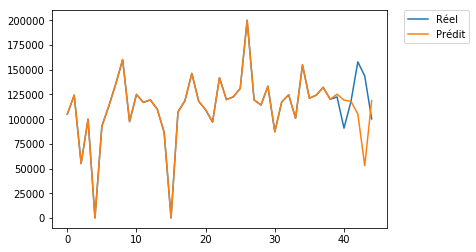

In [28]:
plot_prediction(40,400,5)

In [23]:
def plot_prediction(deb_index_prediction = 40,col = 400,horizon=6):
    valeur = train_lstm[train_lstm.mois <= deb_index_prediction+horizon].iloc[:,col]
    predict_valeur_deb = train_lstm[train_lstm.mois < deb_index_prediction].iloc[:,col]
    predict_valeur_fin = predictions[(predictions.mois >= deb_index_prediction) & (predictions.type == 'predit')]
    predict_valeur_fin.index = list(range(deb_index_prediction-1,horizon+deb_index_prediction))
    predict_valeur = pd.concat([predict_valeur_deb,predict_valeur_fin.iloc[:,col]])



    plt1 = plt.plot(valeur,label='Réel')
    plt2 = plt.plot(predict_valeur,label='Prédit')
    #plt.plot(testPredictPlot)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


    plt.show()

In [77]:
deb_index_prediction = 40
col = 404
horizon=6

In [78]:
valeur = train_lstm[train_lstm.mois <= deb_index_prediction].iloc[:,col]
predict_valeur_deb = train_lstm[train_lstm.mois < deb_index_prediction].iloc[:,col]
valeur

0     224908.025000
1     237576.920000
2     149659.530000
3     263538.964000
4     255434.785000
5     224733.333333
6     219716.666667
7     224000.000000
8     222408.333333
9     214333.333333
10    251193.333333
11    231723.333333
12    237816.666667
13    240350.000000
14    240714.152500
15    169933.333333
16    214133.333333
17    219450.000000
18    204841.428571
19    216750.000000
20    214915.000000
21    251175.000000
22    238314.285714
23    205375.000000
24    238866.666667
25    246200.000000
26    230750.000000
27    251250.000000
28    213811.428571
29    235058.888889
30    219569.090909
31    210375.000000
32    216800.000000
33    242000.000000
34    230025.000000
35    225750.000000
36    213593.333333
37    257300.000000
38    221283.333333
39    695111.300000
Name: valeur_5353, dtype: float64

In [79]:
predict_valeur_fin = predictions[(predictions.mois >= deb_index_prediction) & (predictions.type == 'predit')]
predict_valeur_fin

,valeur_16,valeur_26,valeur_34,valeur_40,valeur_50,valeur_54,valeur_62,valeur_73,valeur_83,valeur_99,...,valeur_62474,valeur_62475,valeur_62486,valeur_62493,valeur_62503,valeur_62524,valeur_62528,valeur_62538,mois,type
0,281153.843750,204953.953125,0.0,74540.171875,93391.101562,126703.140625,383944.06250,206460.406250,131795.937500,192085.859375,...,102660.062500,2342265.25,333129.71875,99327.804688,332389.37500,0.0,114229.890625,146071.765625,40,predit
0,247122.437500,164682.156250,0.0,75362.882812,90794.320312,58206.976562,351263.25000,159201.062500,182401.140625,151771.203125,...,132193.984375,2234670.75,262156.18750,77764.773438,443748.90625,0.0,189372.984375,140082.765625,40,predit
0,232399.015625,168478.859375,0.0,85673.023438,102666.703125,196790.171875,356379.06250,179205.359375,136250.906250,213077.921875,...,103563.179688,2581658.00,325686.78125,131365.812500,331536.93750,0.0,117989.445312,186390.203125,41,predit
0,237460.812500,153719.859375,0.0,81162.570312,109553.500000,209502.984375,361315.87500,165522.953125,153377.781250,199534.484375,...,165866.796875,2350636.00,271953.06250,120899.710938,298782.62500,0.0,216529.234375,181258.640625,42,predit
0,238803.796875,174176.171875,0.0,61916.121094,97528.289062,128531.554688,341002.40625,144348.171875,227815.234375,180145.593750,...,115419.976562,2878644.00,290015.53125,90144.750000,628808.06250,0.0,138517.671875,160396.484375,43,predit
0,259552.531250,197008.531250,0.0,62954.457031,99512.609375,161748.437500,349103.87500,130346.007812,218469.875000,200428.640625,...,111344.492188,2857531.75,335661.75000,97047.632812,589424.25000,0.0,108755.796875,158432.843750,44,predit
0,205570.609375,144978.093750,0.0,75632.078125,93052.062500,186823.421875,317923.46875,164483.687500,124083.554688,191910.312500,...,94975.156250,2318054.75,299124.87500,112381.468750,271727.62500,0.0,105162.296875,170008.296875,45,predit


In [82]:
predict_valeur_fin.index = list(range(deb_index_prediction-1,deb_index_prediction+horizon))
predict_valeur_fin.index

Int64Index([39, 40, 41, 42, 43, 44, 45], dtype='int64')

In [83]:
predict_valeur = pd.concat([predict_valeur_deb,predict_valeur_fin.iloc[:,col]])
predict_valeur

0     224908.025000
1     237576.920000
2     149659.530000
3     263538.964000
4     255434.785000
5     224733.333333
6     219716.666667
7     224000.000000
8     222408.333333
9     214333.333333
10    251193.333333
11    231723.333333
12    237816.666667
13    240350.000000
14    240714.152500
15    169933.333333
16    214133.333333
17    219450.000000
18    204841.428571
19    216750.000000
20    214915.000000
21    251175.000000
22    238314.285714
23    205375.000000
24    238866.666667
25    246200.000000
26    230750.000000
27    251250.000000
28    213811.428571
29    235058.888889
30    219569.090909
31    210375.000000
32    216800.000000
33    242000.000000
34    230025.000000
35    225750.000000
36    213593.333333
37    257300.000000
38    221283.333333
39    247819.046875
40    244149.171875
41    271986.968750
42    284490.500000
43    233991.593750
44    238457.906250
45    240247.015625
Name: valeur_5353, dtype: float64

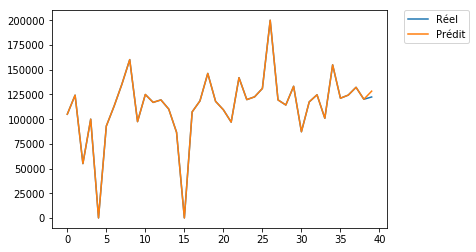

In [40]:



plt1 = plt.plot(valeur,label='Réel')
plt2 = plt.plot(predict_valeur,label='Prédit')
#plt.plot(testPredictPlot)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

In [ ]:
predictions.type == 

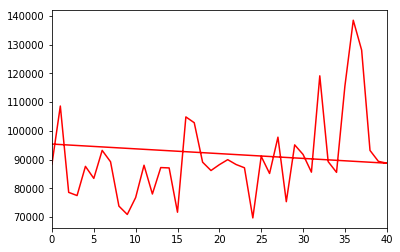

In [205]:
deb_index_prediction = 40
valeur = predictions[predictions.mois <= deb_index_prediction].iloc[:,4]
pred = pd.concat([valeur, predictions.iloc[:,4]])
# gca stands for 'get current axis'
ax = plt.gca()
valeur.plot(kind='line',ax=ax,color = '#FFFFFF')
pred.plot(kind='line',ax=ax,color = '#FF0000')
plt.show()

In [ ]:
### define model
n_features = train_lstm.shape[1]


model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=0)
# make a one step prediction out of sample
x_input = array([[90, 95], [100, 105]]).reshape((1, n_input, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

In [ ]:
for i in range(1):
	x, y = generator[i]
	print('%s => %s' % (x, y))

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.layers import Flatten

kernel_initialiser = 'normal'

nb_features # contient le nombre de features sans le type de bien ( ie mois, lags et diffs )

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
# notre entrée ici est un simple entier donc shape = 1
main_input = Input(shape=(1,), dtype='int32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=20, input_dim=nb_type_bien, input_length=1,embeddings_initializer=kernel_initialiser)(main_input)

#Argument must be a dense tensor: ((4750,), 512) - got shape [2], but wanted [2, 1].

auxiliary_input = Input(shape=(nb_features,), name='aux_input')

x = Flatten()(x)

x = keras.layers.concatenate([x, auxiliary_input])

x = Dense(30, activation='relu',kernel_initializer=kernel_initialiser)(x)

x = Dense(100, activation='relu',kernel_initializer=kernel_initialiser)(x)

x = Dense(100, activation='relu',kernel_initializer=kernel_initialiser)(x)

main_output = Dense(1, name='main_output', activation='relu',kernel_initializer='normal')(x)

model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])


In [ ]:
sgd = keras.optimizers.Adam(lr=0.001)
#sgd = keras.optimizers.RMSprop(lr=0.01)
model.compile(optimizer=sgd, loss="mean_squared_logarithmic_error")

# 3. Walk Forward Validation

La validation du modèle est réalisé grace à une Walk Forward Validation. On entraine le modèle sur 10 années pour prédire l'année suivante et on déplace la fenêtre d'année en année

In [24]:
45-12

33

In [25]:
30-12

18

In [26]:
from sklearn.ensemble import RandomForestRegressor

mean_error = []
for mois in range(18,22):
    train = immo_train2[immo_train2['mois'] < mois]
    val = immo_train2[immo_train2['mois'] == mois]
    
    test_headline_data = val['id_bien']
    test_additional_data = val.drop(columns=['id_bien','valeur','mois'])
    test_labels = val['valeur']
    
    headline_data = train['id_bien']
    additional_data = train.drop(columns=['id_bien','valeur','mois'])
    labels = train['valeur']
    
    print("mois : " + str(mois+12))
    
    model.fit([headline_data, additional_data], [labels], epochs=4, batch_size=32)
    
    preds = np.squeeze(model.predict([test_headline_data, test_additional_data]))
    
    error = rmsle(test_labels, preds)
    print('Week %d - Error %.5f' % (mois+12, error))
    mean_error.append(error)
    print('Mean Error inter = %.5f' % np.mean(mean_error))
print('Mean Error Final = %.5f' % np.mean(mean_error))




mois : 30
Instructions for updating:
Use tf.cast instead.
Epoch 1/4
80750/80750 [==============================] - 4s 52us/step - loss: 16.3162
Epoch 2/4
80750/80750 [==============================] - 4s 48us/step - loss: 7.1621
Epoch 3/4
80750/80750 [==============================] - 4s 50us/step - loss: 6.8672
Epoch 4/4
80750/80750 [==============================] - 4s 48us/step - loss: 6.7482
Week 30 - Error 2.02923
Mean Error inter = 2.02923
mois : 31
Epoch 1/4
85500/85500 [==============================] - 4s 47us/step - loss: 6.5558
Epoch 2/4
85500/85500 [==============================] - 4s 49us/step - loss: 6.5293
Epoch 3/4
85500/85500 [==============================] - 5s 54us/step - loss: 6.5100
Epoch 4/4
85500/85500 [==============================] - 4s 52us/step - loss: 6.4930
Week 31 - Error 1.79007
Mean Error inter = 1.90965
mois : 32
Epoch 1/4
90250/90250 [==============================] - 6s 62us/step - loss: 6.3085
Epoch 2/4
90250/90250 [==============================]

In [33]:
pd.DataFrame(labels).describe()

,valeur
count,9.500000e+04
mean,2.082349e+05
std,3.068302e+05
min,0.000000e+00
25%,1.126931e+05
50%,1.671459e+05
75%,2.457614e+05
max,6.085667e+07


In [277]:
error = rmsle(test_labels, preds)

In [437]:
error

2.0023613562879437

In [394]:
type(test_labels.values)

numpy.ndarray

In [395]:
test_labels.values.shape

(4750,)

In [391]:
preds.shape

(4750, 1)

In [398]:
print(np.squeeze(preds))

[ 0.0084166  -0.00675052 -0.00555914 ... -0.00019156  0.00814748
  0.00096494]


In [386]:
print(preds)

[[ 0.0084166 ]
 [-0.00675052]
 [-0.00555914]
 ...
 [-0.00019156]
 [ 0.00814748]
 [ 0.00096494]]


In [ ]:
    xtr, xts = train.drop(['valeur','id_bien'], axis=1), val.drop(['valeur','id_bien'], axis=1)
    ytr, yts = train['valeur'].values, val['valeur'].values
    
    mdl = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (mois, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))